# Napari Plugin Infrastructure Analysis

This notebook provides comprehensive analysis of the napari plugin ecosystem, focusing on:
- Python version support patterns
- Napari dependency and pinning strategies  
- Version compatibility assessment
- Testing infrastructure adoption
- Ecosystem health visualizations

Data sources: npe2api public data including PyPI metadata, classifiers, conda packages, and GitHub activity metrics.

## 1. Import Required Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import re
from collections import defaultdict, Counter
from packaging import version
from packaging.specifiers import SpecifierSet
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Define paths
NPE2API_DATA = Path("../npe2api/public")
OUTPUT_DIR = Path("reports")
OUTPUT_DIR.mkdir(exist_ok=True)

print("Libraries imported successfully!")
print(f"npe2api data path: {NPE2API_DATA}")
print(f"Output directory: {OUTPUT_DIR}")

# Check if npe2api data is available
if NPE2API_DATA.exists():
    print(f"✓ npe2api data found at {NPE2API_DATA}")
    pypi_files = list((NPE2API_DATA / "pypi").glob("*.json"))
    github_files = list((NPE2API_DATA / "github").glob("*.json"))
    print(f"Found {len(pypi_files)} PyPI metadata files")
    print(f"Found {len(github_files)} GitHub metadata files")
else:
    print(f"❌ npe2api data not found at {NPE2API_DATA}")

Libraries imported successfully!
npe2api data path: ..\npe2api\public
Output directory: reports
✓ npe2api data found at ..\npe2api\public
Found 607 PyPI metadata files
Found 405 GitHub metadata files


## 2. Load and Parse Plugin Data

Load all available plugin metadata from the npe2api public data sources.

In [27]:
def load_pypi_metadata():
    """Load all PyPI metadata files."""
    pypi_data = {}
    pypi_dir = NPE2API_DATA / "pypi"
    
    if not pypi_dir.exists():
        print(f"❌ PyPI directory not found at {pypi_dir}")
        return pypi_data
        
    for json_file in pypi_dir.glob("*.json"):
        plugin_name = json_file.stem
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                pypi_data[plugin_name] = data
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    
    print(f"Loaded PyPI metadata for {len(pypi_data)} plugins")
    return pypi_data

def load_github_metadata():
    """Load all GitHub metadata files."""
    github_data = {}
    github_dir = NPE2API_DATA / "github"
    
    if not github_dir.exists():
        print(f"❌ GitHub directory not found at {github_dir}")
        return github_data
        
    for json_file in github_dir.glob("*.json"):
        plugin_name = json_file.stem
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                github_data[plugin_name] = data
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    
    print(f"Loaded GitHub metadata for {len(github_data)} plugins")
    return github_data

def load_classifiers():
    """Load plugin classifiers data."""
    classifiers_file = NPE2API_DATA / "classifiers.json"
    
    if not classifiers_file.exists():
        print(f"❌ Classifiers file not found at {classifiers_file}")
        return {}
        
    try:
        with open(classifiers_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Loaded classifiers for {sum(len(cat_plugins) for cat_plugins in data.values())} total plugins")
        return data
    except Exception as e:
        print(f"Error loading classifiers: {e}")
        return {}

# Load all data
print("Loading plugin data...")
pypi_data = load_pypi_metadata()
github_data = load_github_metadata()  
classifiers_data = load_classifiers()

print("\n📊 Data Loading Summary:")
print(f"PyPI metadata: {len(pypi_data)} plugins")
print(f"GitHub metadata: {len(github_data)} plugins")
print(f"Classifier categories: {list(classifiers_data.keys()) if classifiers_data else 'None'}")

# Show sample of what's loaded
if pypi_data:
    sample_plugin = list(pypi_data.keys())[0]
    print(f"\n🔍 Sample plugin structure ({sample_plugin}):")
    sample_data = pypi_data[sample_plugin]
    if 'info' in sample_data:
        info = sample_data['info']
        print(f"  - Name: {info.get('name', 'N/A')}")
        print(f"  - Version: {info.get('version', 'N/A')}")
        print(f"  - Python requirement: {info.get('requires_python', 'N/A')}")
        print(f"  - Classifiers: {len(info.get('classifiers', []))} items")
        print(f"  - Dependencies: {len(info.get('requires_dist', []))} items")

Loading plugin data...
Loaded PyPI metadata for 607 plugins
Loaded GitHub metadata for 405 plugins
Loaded classifiers for 603 total plugins

📊 Data Loading Summary:
PyPI metadata: 607 plugins
GitHub metadata: 405 plugins
Classifier categories: ['active', 'withdrawn', 'deleted']

🔍 Sample plugin structure (acquifer-napari):
  - Name: acquifer-napari
  - Version: 0.0.2
  - Python requirement: >=3.7
  - Classifiers: 9 items
  - Dependencies: 6 items


## 3. Analyze Python Version Support

Extract and analyze Python version support from Trove classifiers.

In [28]:
def extract_python_versions(plugin_data):
    """Extract supported Python versions from classifiers and requires_python."""
    results = []
    
    for plugin_name, data in plugin_data.items():
        if 'info' not in data:
            continue
            
        info = data['info']
        classifiers = info.get('classifiers', [])
        requires_python = info.get('requires_python', '')
        
        # Extract Python version classifiers
        python_versions = []
        for classifier in classifiers:
            if classifier.startswith('Programming Language :: Python :: '):
                version_part = classifier.replace('Programming Language :: Python :: ', '')
                # Filter out non-version classifiers
                if re.match(r'^\d+(\.\d+)*$', version_part):
                    python_versions.append(version_part)
        
        results.append({
            'plugin_name': plugin_name,
            'python_versions_classifiers': python_versions,
            'requires_python': requires_python,
            'num_python_versions': len(python_versions),
            'supports_python_3': any(v.startswith('3') for v in python_versions),
            'latest_python_version': max(python_versions, key=lambda x: tuple(map(int, x.split('.')))) if python_versions else None
        })
    
    return pd.DataFrame(results)

# Extract Python version support
print("🐍 Analyzing Python version support...")
python_support_df = extract_python_versions(pypi_data)

print(f"\nAnalyzed {len(python_support_df)} plugins")
print(f"Plugins with Python version classifiers: {len(python_support_df[python_support_df['num_python_versions'] > 0])}")
print(f"Plugins with requires_python specified: {len(python_support_df[python_support_df['requires_python'] != ''])}")

# Summary statistics
print("\n📊 Python Version Support Summary:")
print(f"Average Python versions supported per plugin: {python_support_df['num_python_versions'].mean():.1f}")
print(f"Plugins supporting Python 3: {python_support_df['supports_python_3'].sum()}")
print(f"Plugins with no version info: {len(python_support_df[python_support_df['num_python_versions'] == 0])}")

# Most common Python versions
all_versions = []
for versions in python_support_df['python_versions_classifiers']:
    all_versions.extend(versions)

if all_versions:
    version_counts = Counter(all_versions)
    print(f"\n🏆 Most common Python versions:")
    for version, count in version_counts.most_common(10):
        percentage = (count / len(python_support_df)) * 100
        print(f"  Python {version}: {count} plugins ({percentage:.1f}%)")

# Show some examples
print(f"\n🔍 Sample plugins with version info:")
sample_with_versions = python_support_df[python_support_df['num_python_versions'] > 0].head(5)
for _, row in sample_with_versions.iterrows():
    print(f"  {row['plugin_name']}: {', '.join(row['python_versions_classifiers'])}")

python_support_df.head()

🐍 Analyzing Python version support...

Analyzed 607 plugins
Plugins with Python version classifiers: 587
Plugins with requires_python specified: 600

📊 Python Version Support Summary:
Average Python versions supported per plugin: 3.8
Plugins supporting Python 3: 587
Plugins with no version info: 20

🏆 Most common Python versions:
  Python 3: 547 plugins (90.1%)
  Python 3.9: 466 plugins (76.8%)
  Python 3.10: 433 plugins (71.3%)
  Python 3.8: 355 plugins (58.5%)
  Python 3.11: 204 plugins (33.6%)
  Python 3.12: 160 plugins (26.4%)
  Python 3.7: 111 plugins (18.3%)
  Python 3.13: 56 plugins (9.2%)
  Python 3.6: 3 plugins (0.5%)

🔍 Sample plugins with version info:
  acquifer-napari: 3, 3.7, 3.8, 3.9
  affinder: 3, 3.10, 3.11, 3.9
  allencell-segmenter-ml: 3, 3.10, 3.9
  alveoleye: 3, 3.10, 3.8, 3.9
  anchor-droplet-chip: 3


,plugin_name,python_versions_classifiers,requires_python,num_python_versions,supports_python_3,latest_python_version
0,acquifer-napari,"[3, 3.7, 3.8, 3.9]",>=3.7,4,True,3.9
1,affinder,"[3, 3.10, 3.11, 3.9]",>=3.9,4,True,3.11
2,allencell-segmenter-ml,"[3, 3.10, 3.9]","<3.11,>=3.9",3,True,3.10
3,alveoleye,"[3, 3.10, 3.8, 3.9]",>=3.8,4,True,3.10
4,anchor-droplet-chip,[3],>=3.8,1,True,3


## 4. Examine Napari Dependency Patterns

Analyze how plugins depend on napari and identify version pinning strategies.

In [19]:
def parse_napari_dependencies(plugin_data):
    """Parse napari dependency specifications from requires_dist."""
    results = []
    
    for plugin_name, data in plugin_data.items():
        if 'info' not in data:
            continue
            
        info = data['info']
        requires_dist = info.get('requires_dist', [])
        
        napari_deps = []
        has_napari_dep = False
        napari_spec = None
        napari_pin_type = 'none'
        
        if requires_dist:
            for dep in requires_dist:
                # Look for exact napari dependencies (not napari-* packages)
                if dep:
                    # Handle extras and conditions first
                    base_dep = dep.split(';')[0].strip()  # Remove conditions like "extra == 'testing'"
                    
                    # Extract package name (before any version specifiers)
                    package_name = re.split(r'[<>=!\[\s]', base_dep)[0].strip()
                    
                    # Only match exact "napari" package (case insensitive)
                    if package_name.lower() == 'napari':
                        napari_deps.append(dep)
                        has_napari_dep = True
                        napari_spec = base_dep
                        
                        # Classify pin type - handle complex specs like ">=0.4.17,<0.5.0"
                        spec_clean = base_dep.replace(package_name, '', 1).strip()
                        
                        if '>=' in spec_clean and ('<=' in spec_clean or '<' in spec_clean):
                            napari_pin_type = 'range'
                        elif '>=' in spec_clean and '>' in spec_clean:
                            napari_pin_type = 'range'  # e.g., ">0.4.0,>=0.4.17"
                        elif '>=' in spec_clean:
                            napari_pin_type = 'minimum'
                        elif '==' in spec_clean:
                            napari_pin_type = 'exact'
                        elif '<=' in spec_clean or '<' in spec_clean:
                            napari_pin_type = 'maximum'
                        elif '>' in spec_clean:
                            napari_pin_type = 'minimum'
                        elif spec_clean.strip() == '':
                            napari_pin_type = 'unpinned'
                        else:
                            napari_pin_type = 'complex'
        
        results.append({
            'plugin_name': plugin_name,
            'has_napari_dependency': has_napari_dep,
            'napari_dependencies': napari_deps,
            'napari_specification': napari_spec,
            'napari_pin_type': napari_pin_type,
            'num_napari_deps': len(napari_deps)
        })
    
    return pd.DataFrame(results)

def categorize_napari_compatibility(spec):
    """Categorize napari compatibility based on version specification."""
    if not spec:
        return 'no_constraint'
    
    # Current napari version (as of September 2025)
    current_napari = "0.5.3"  # Updated to reflect current date
    
    try:
        # Remove package name to get just the version spec
        spec_clean = re.sub(r'^napari\s*', '', spec, flags=re.IGNORECASE).strip()
        
        if not spec_clean:
            return 'unpinned'
            
        # Use packaging library to properly parse version specifications
        spec_set = SpecifierSet(spec_clean)
        from packaging.version import Version
        current_version = Version(current_napari)
        
        # Check if current napari version satisfies the spec
        is_compatible = current_version in spec_set
        
        # Categorize based on the type of specification
        if '>=' in spec_clean and ('<=' in spec_clean or '<' in spec_clean):
            return 'range_compatible' if is_compatible else 'range_incompatible'
        elif '==' in spec_clean:
            return 'exact_compatible' if is_compatible else 'exact_incompatible'
        elif '>=' in spec_clean or '>' in spec_clean:
            return 'minimum_compatible' if is_compatible else 'minimum_incompatible'
        elif '<=' in spec_clean or '<' in spec_clean:
            return 'maximum_compatible' if is_compatible else 'maximum_incompatible'
        else:
            return 'complex_compatible' if is_compatible else 'complex_incompatible'
            
    except Exception as e:
        print(f"Error parsing spec '{spec}': {e}")
        return 'malformed'

# Analyze napari dependencies
print("🔗 Analyzing napari dependency patterns...")
napari_deps_df = parse_napari_dependencies(pypi_data)

# Add compatibility categorization
napari_deps_df['compatibility_category'] = napari_deps_df['napari_specification'].apply(categorize_napari_compatibility)

print(f"\nAnalyzed {len(napari_deps_df)} plugins")
print(f"Plugins with napari dependencies: {napari_deps_df['has_napari_dependency'].sum()}")

# Dependency statistics
print("\n📊 Napari Dependency Summary:")
pin_type_counts = napari_deps_df['napari_pin_type'].value_counts()
for pin_type, count in pin_type_counts.items():
    percentage = (count / len(napari_deps_df)) * 100
    print(f"  {pin_type.replace('_', ' ').title()}: {count} plugins ({percentage:.1f}%)")

print(f"\n🔍 Compatibility Categories:")
compat_counts = napari_deps_df['compatibility_category'].value_counts()
for category, count in compat_counts.items():
    percentage = (count / len(napari_deps_df)) * 100
    print(f"  {category.replace('_', ' ').title()}: {count} plugins ({percentage:.1f}%)")

# Show examples of different dependency patterns
print(f"\n📝 Example Dependency Patterns:")
examples = napari_deps_df[napari_deps_df['has_napari_dependency']].groupby('napari_pin_type').head(2)
for _, row in examples.iterrows():
    print(f"  {row['plugin_name']} ({row['napari_pin_type']}): {row['napari_specification']}")

napari_deps_df.head()
print(f"  {pin_type.replace('_', ' ').title()}: {count} plugins ({percentage:.1f}%)")

print(f"\n🔍 Compatibility Categories:")
compat_counts = napari_deps_df['compatibility_category'].value_counts()
for category, count in compat_counts.items():
    percentage = (count / len(napari_deps_df)) * 100
    print(f"  {category.replace('_', ' ').title()}: {count} plugins ({percentage:.1f}%)")

# Show examples of different dependency patterns
print(f"\n📝 Example Dependency Patterns:")
examples = napari_deps_df[napari_deps_df['has_napari_dependency']].groupby('napari_pin_type').head(2)
for _, row in examples.iterrows():
    print(f"  {row['plugin_name']} ({row['napari_pin_type']}): {row['napari_specification']}")

# Show examples of different dependency patterns
print(f"\n📝 Example Dependency Patterns:")
examples = napari_deps_df[napari_deps_df['has_napari_dependency']].groupby('napari_pin_type').head(2)

🔗 Analyzing napari dependency patterns...
Error parsing spec 'napari[pyqt5]!=0.4.18': Invalid specifier: '[pyqt5]!=0.4.18'
Error parsing spec 'napari[all]': Invalid specifier: '[all]'
Error parsing spec 'napari[all]>=0.6.0': Invalid specifier: '[all]>=0.6.0'
Error parsing spec 'napari[all]': Invalid specifier: '[all]'
Error parsing spec 'napari[pyqt5]': Invalid specifier: '[pyqt5]'
Error parsing spec 'napari[pyqt5]!=0.6.0,>=0.5': Invalid specifier: '[pyqt5]!=0.6.0'
Error parsing spec 'napari[all]>=0.5.0': Invalid specifier: '[all]>=0.5.0'
Error parsing spec 'napari[all]>=0.4.19': Invalid specifier: '[all]>=0.4.19'
Error parsing spec 'napari[pyqt5]': Invalid specifier: '[pyqt5]'
Error parsing spec 'napari[all]': Invalid specifier: '[all]'
Error parsing spec 'napari[all] (>=0.4.6)': Invalid specifier: '[all] (>=0.4.6)'
Error parsing spec 'napari[all]': Invalid specifier: '[all]'
Error parsing spec 'napari[all]>=0.4.18': Invalid specifier: '[all]>=0.4.18'
Error parsing spec 'napari (>=0.4

## 5. Assess Napari Version Compatibility

Analyze potential compatibility issues and generate compatibility matrices.

In [17]:
def assess_compatibility_conflicts(napari_deps_df):
    """Identify potential compatibility conflicts between plugins."""
    
    # Focus on plugins with specific version requirements
    constrained_plugins = napari_deps_df[
        napari_deps_df['napari_pin_type'].isin(['range', 'exact', 'maximum'])
    ].copy()
    
    conflicts = []
    compatibility_matrix = {}
    
    # Simulate napari versions to test against
    test_napari_versions = ['0.4.15', '0.4.16', '0.4.17', '0.4.18', '0.4.19', '0.5.0', '0.5.1']
    
    for plugin_idx, plugin_row in constrained_plugins.iterrows():
        plugin_name = plugin_row['plugin_name']
        spec_str = plugin_row['napari_specification']
        
        if not spec_str:
            continue
            
        compatible_versions = []
        
        for test_version in test_napari_versions:
            try:
                # Parse the specification
                spec_clean = re.sub(r'napari\s*', '', spec_str, flags=re.IGNORECASE).strip()
                spec_clean = re.sub(r'^[><=!]+', lambda m: m.group(), spec_clean)
                
                # Simple compatibility check
                is_compatible = True
                
                if '>=' in spec_str:
                    min_version = re.search(r'>=\s*([0-9.]+)', spec_str)
                    if min_version:
                        min_ver = min_version.group(1)
                        from packaging.version import Version
                        is_compatible &= Version(test_version) >= Version(min_ver)
                
                if '<' in spec_str and not '<=' in spec_str:
                    max_version = re.search(r'<\s*([0-9.]+)', spec_str)
                    if max_version:
                        max_ver = max_version.group(1)
                        from packaging.version import Version
                        is_compatible &= Version(test_version) < Version(max_ver)
                        
                if '<=' in spec_str:
                    max_version = re.search(r'<=\s*([0-9.]+)', spec_str)
                    if max_version:
                        max_ver = max_version.group(1)
                        from packaging.version import Version
                        is_compatible &= Version(test_version) <= Version(max_ver)
                
                if '==' in spec_str:
                    exact_version = re.search(r'==\s*([0-9.]+)', spec_str)
                    if exact_version:
                        exact_ver = exact_version.group(1)
                        from packaging.version import Version
                        is_compatible = Version(test_version) == Version(exact_ver)
                
                if is_compatible:
                    compatible_versions.append(test_version)
                    
            except Exception as e:
                print(f"Error parsing {plugin_name}: {spec_str} - {e}")
        
        compatibility_matrix[plugin_name] = {
            'specification': spec_str,
            'compatible_versions': compatible_versions,
            'compatibility_score': len(compatible_versions) / len(test_napari_versions)
        }
    
    return compatibility_matrix

def find_problematic_plugins(compatibility_matrix, threshold=0.5):
    """Find plugins with low compatibility scores."""
    problematic = []
    
    for plugin_name, compat_info in compatibility_matrix.items():
        if compat_info['compatibility_score'] < threshold:
            problematic.append({
                'plugin_name': plugin_name,
                'specification': compat_info['specification'],
                'compatibility_score': compat_info['compatibility_score'],
                'compatible_versions': compat_info['compatible_versions']
            })
    
    return sorted(problematic, key=lambda x: x['compatibility_score'])

# Assess compatibility
print("🔍 Assessing napari version compatibility...")
compatibility_matrix = assess_compatibility_conflicts(napari_deps_df)

print(f"Analyzed compatibility for {len(compatibility_matrix)} constrained plugins")

# Find problematic plugins
problematic_plugins = find_problematic_plugins(compatibility_matrix, threshold=0.6)

print(f"\n⚠️  Potentially Problematic Plugins (compatibility < 60%):")
print(f"Found {len(problematic_plugins)} plugins with potential compatibility issues")

for plugin in problematic_plugins[:10]:  # Show top 10 most problematic
    score_percent = plugin['compatibility_score'] * 100
    print(f"  {plugin['plugin_name']}: {score_percent:.1f}% compatibility")
    print(f"    Spec: {plugin['specification']}")
    print(f"    Compatible with: {', '.join(plugin['compatible_versions'])}")
    print()

# Overall compatibility statistics
if compatibility_matrix:
    all_scores = [info['compatibility_score'] for info in compatibility_matrix.values()]
    avg_compatibility = np.mean(all_scores)
    print(f"\n📊 Compatibility Statistics:")
    print(f"Average compatibility score: {avg_compatibility:.2%}")
    print(f"Plugins with 100% compatibility: {sum(1 for score in all_scores if score == 1.0)}")
    print(f"Plugins with <50% compatibility: {sum(1 for score in all_scores if score < 0.5)}")

# Create compatibility summary for visualization
compat_summary_df = pd.DataFrame([
    {
        'plugin_name': name,
        'specification': info['specification'], 
        'compatibility_score': info['compatibility_score'],
        'num_compatible_versions': len(info['compatible_versions'])
    }
    for name, info in compatibility_matrix.items()
])

print(f"\n🎯 Plugins needing attention (lowest compatibility):")
if not compat_summary_df.empty:
    worst_compat = compat_summary_df.nsmallest(5, 'compatibility_score')
    for _, row in worst_compat.iterrows():
        print(f"  {row['plugin_name']}: {row['compatibility_score']:.1%}")

compat_summary_df.head() if not compat_summary_df.empty else "No compatibility data available"

🔍 Assessing napari version compatibility...
Analyzed compatibility for 72 constrained plugins

⚠️  Potentially Problematic Plugins (compatibility < 60%):
Found 38 plugins with potential compatibility issues
  blik: 0.0% compatibility
    Spec: napari[all]>=0.6.0
    Compatible with: 

  brainglobe-napari-io: 0.0% compatibility
    Spec: napari>=0.6.1
    Compatible with: 

  brainrender-napari: 0.0% compatibility
    Spec: napari>=0.6.1
    Compatible with: 

  ebi-oct: 0.0% compatibility
    Spec: napari>=0.6.1
    Compatible with: 

  movement: 0.0% compatibility
    Spec: napari[all]>=0.6.0
    Compatible with: 

  napari-3d-counter: 0.0% compatibility
    Spec: napari==0.6.4
    Compatible with: 

  napari-bioio-reader: 0.0% compatibility
    Spec: napari[all]<0.7,>=0.6.2
    Compatible with: 

  napari-dinosim: 0.0% compatibility
    Spec: napari>=0.5.6
    Compatible with: 

  napari-plot: 0.0% compatibility
    Spec: napari (<0.4.15,>=0.4.13)
    Compatible with: 

  napari-roxa

,plugin_name,specification,compatibility_score,num_compatible_versions
0,allencell-segmenter-ml,napari>=0.4.18,0.571429,4
1,arcos-gui,napari>=0.4.14,1.000000,7
2,blik,napari[all]>=0.6.0,0.000000,0
3,brainglobe-napari-io,napari>=0.6.1,0.000000,0
4,brainglobe-registration,"napari!=0.6.0,>=0.4.18",0.571429,4


## 6. Detect Testing Infrastructure

Analyze testing frameworks and CI configurations across plugins.

In [18]:
def detect_testing_infrastructure(plugin_data):
    """Detect testing frameworks and tools in plugin dependencies."""
    
    # Common testing frameworks and tools
    testing_frameworks = {
        'pytest': 'pytest',
        'unittest': 'unittest',  # usually builtin, might not appear in deps
        'nose': 'nose',
        'tox': 'tox',
        'coverage': 'coverage',
        'codecov': 'codecov',
        'pytest-cov': 'pytest-cov',
        'pytest-qt': 'pytest-qt',
        'pytest-xvfb': 'pytest-xvfb'
    }
    
    ci_indicators = [
        'github-actions', 'travis', 'circleci', 'appveyor', 'azure-pipelines'
    ]
    
    results = []
    
    for plugin_name, data in plugin_data.items():
        if 'info' not in data:
            continue
            
        info = data['info']
        requires_dist = info.get('requires_dist', [])
        
        detected_frameworks = []
        has_test_deps = False
        has_ci_deps = False
        
        if requires_dist:
            for dep in requires_dist:
                if not dep:
                    continue
                    
                dep_lower = dep.lower()
                
                # Check for testing frameworks
                for framework_key, framework_name in testing_frameworks.items():
                    if framework_key in dep_lower:
                        detected_frameworks.append(framework_name)
                        has_test_deps = True
                
                # Check for CI-related dependencies
                for ci_tool in ci_indicators:
                    if ci_tool in dep_lower:
                        has_ci_deps = True
                
                # Check for 'testing' extra or test-related conditions
                if 'extra == "testing"' in dep or 'extra == "test"' in dep:
                    has_test_deps = True
        
        # Remove duplicates
        detected_frameworks = list(set(detected_frameworks))
        
        results.append({
            'plugin_name': plugin_name,
            'has_testing_deps': has_test_deps,
            'testing_frameworks': detected_frameworks,
            'num_testing_frameworks': len(detected_frameworks),
            'has_pytest': 'pytest' in detected_frameworks,
            'has_coverage': any('cov' in fw for fw in detected_frameworks),
            'has_tox': 'tox' in detected_frameworks,
            'has_ci_deps': has_ci_deps
        })
    
    return pd.DataFrame(results)

def analyze_github_activity(github_data):
    """Analyze GitHub repository activity as proxy for maintenance."""
    results = []
    
    for plugin_name, data in github_data.items():
        activity = data.get('activity', {})
        
        # Parse last commit date
        last_commit_date = None
        if 'last_commit' in activity and 'date' in activity['last_commit']:
            try:
                last_commit_date = pd.to_datetime(activity['last_commit']['date'])
            except:
                pass
        
        # Calculate days since last commit
        days_since_last_commit = None
        if last_commit_date:
            # Ensure both timestamps are timezone-aware or both are naive
            now = pd.Timestamp.now(tz='UTC')
            if last_commit_date.tz is None:
                # If last_commit_date is naive, make now naive too
                now = pd.Timestamp.now()
            elif now.tz is None:
                # If now is naive but last_commit_date has tz, localize now
                now = now.tz_localize('UTC')
            days_since_last_commit = (now - last_commit_date).days
        
        results.append({
            'plugin_name': plugin_name,
            'open_issues': activity.get('open_issues', 0),
            'pull_requests': activity.get('pull_requests', 0),
            'forks': activity.get('forks', 0),
            'stars': activity.get('stars', 0),
            'watchers': activity.get('watchers', 0),
            'is_archived': activity.get('is_archived', False),
            'last_commit_date': last_commit_date,
            'days_since_last_commit': days_since_last_commit,
            'vulnerability_alerts': activity.get('open_runtime_vulnerability_alerts', 0)
        })
    
    return pd.DataFrame(results)

# Analyze testing infrastructure
print("🧪 Analyzing testing infrastructure...")
testing_df = detect_testing_infrastructure(pypi_data)

print(f"\nAnalyzed testing infrastructure for {len(testing_df)} plugins")
print(f"Plugins with testing dependencies: {testing_df['has_testing_deps'].sum()}")

# Testing statistics
print("\n📊 Testing Infrastructure Summary:")
print(f"Plugins using pytest: {testing_df['has_pytest'].sum()} ({testing_df['has_pytest'].mean():.1%})")
print(f"Plugins with coverage tools: {testing_df['has_coverage'].sum()} ({testing_df['has_coverage'].mean():.1%})")
print(f"Plugins using tox: {testing_df['has_tox'].sum()} ({testing_df['has_tox'].mean():.1%})")

# Most common testing frameworks
all_frameworks = []
for frameworks in testing_df['testing_frameworks']:
    all_frameworks.extend(frameworks)

if all_frameworks:
    framework_counts = Counter(all_frameworks)
    print(f"\n🏆 Most common testing frameworks:")
    for framework, count in framework_counts.most_common():
        percentage = (count / len(testing_df)) * 100
        print(f"  {framework}: {count} plugins ({percentage:.1f}%)")

# Analyze GitHub activity for maintenance indicators
print(f"\n🔍 Analyzing GitHub activity...")
if github_data:
    github_activity_df = analyze_github_activity(github_data)
    
    print(f"Analyzed GitHub activity for {len(github_activity_df)} plugins")
    
    # Activity statistics
    active_repos = github_activity_df[github_activity_df['days_since_last_commit'] <= 365]
    print(f"Repositories with commits in last year: {len(active_repos)}")
    
    archived_repos = github_activity_df[github_activity_df['is_archived'] == True]
    print(f"Archived repositories: {len(archived_repos)}")
    
    with_vulnerabilities = github_activity_df[github_activity_df['vulnerability_alerts'] > 0]
    print(f"Repositories with vulnerability alerts: {len(with_vulnerabilities)}")
    
    print(f"\n📈 GitHub Activity Summary:")
    print(f"Average stars per plugin: {github_activity_df['stars'].mean():.1f}")
    print(f"Average forks per plugin: {github_activity_df['forks'].mean():.1f}")
    print(f"Average open issues per plugin: {github_activity_df['open_issues'].mean():.1f}")
    
    if 'days_since_last_commit' in github_activity_df.columns:
        recent_activity = github_activity_df.dropna(subset=['days_since_last_commit'])
        if not recent_activity.empty:
            print(f"Average days since last commit: {recent_activity['days_since_last_commit'].mean():.0f}")

testing_df.head()

print(f"\n🔍 Sample plugins with testing infrastructure:")

sample_with_tests = testing_df[testing_df['has_testing_deps']].head(5)
print(f"  {row['plugin_name']}: {frameworks}")

for _, row in sample_with_tests.iterrows():    
    frameworks = ', '.join(row['testing_frameworks']) if row['testing_frameworks'] else 'Generic'

🧪 Analyzing testing infrastructure...

Analyzed testing infrastructure for 607 plugins
Plugins with testing dependencies: 409

📊 Testing Infrastructure Summary:
Plugins using pytest: 404 (66.6%)
Plugins with coverage tools: 382 (62.9%)
Plugins using tox: 344 (56.7%)

🏆 Most common testing frameworks:
  pytest: 404 plugins (66.6%)
  pytest-cov: 379 plugins (62.4%)
  tox: 344 plugins (56.7%)
  pytest-qt: 340 plugins (56.0%)
  coverage: 19 plugins (3.1%)
  pytest-xvfb: 8 plugins (1.3%)
  codecov: 5 plugins (0.8%)

🔍 Analyzing GitHub activity...
Analyzed GitHub activity for 405 plugins
Repositories with commits in last year: 60
Archived repositories: 6
Repositories with vulnerability alerts: 0

📈 GitHub Activity Summary:
Average stars per plugin: 12.9
Average forks per plugin: 3.2
Average open issues per plugin: 4.3
Average days since last commit: 776

🔍 Sample plugins with testing infrastructure:
  movement: []


## 7. Generate Comprehensive Visualizations

Create publication-ready plots and visualizations for all analyses.

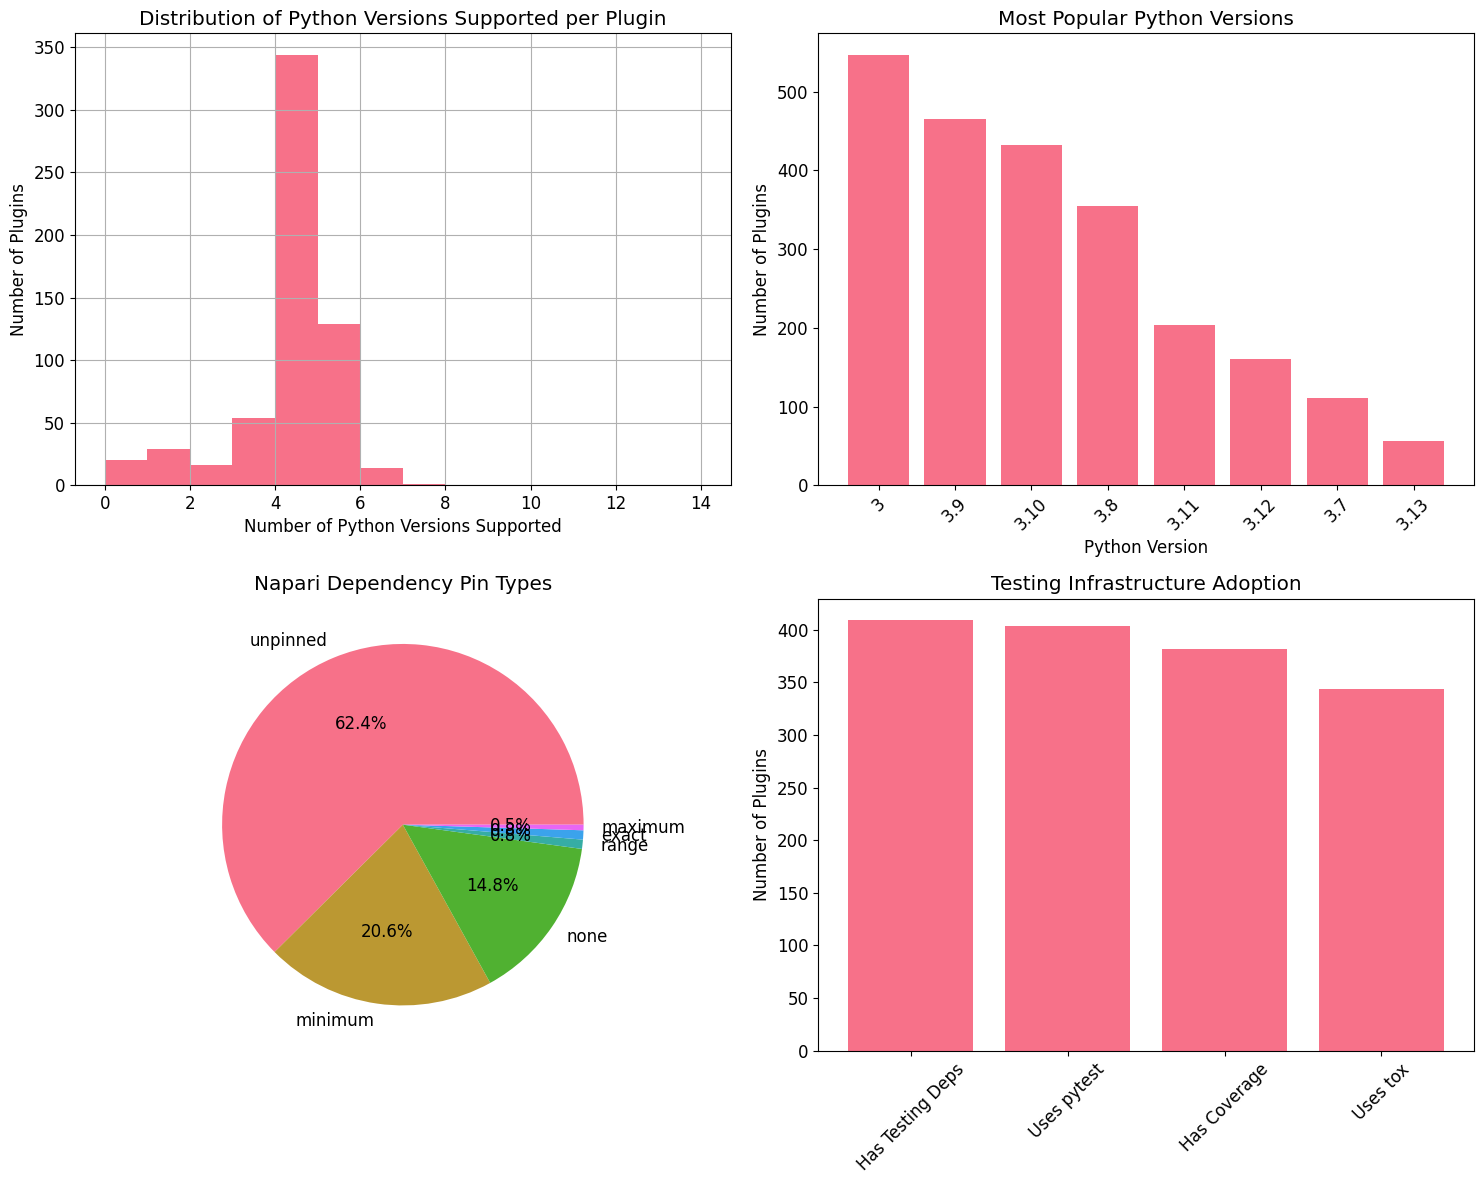

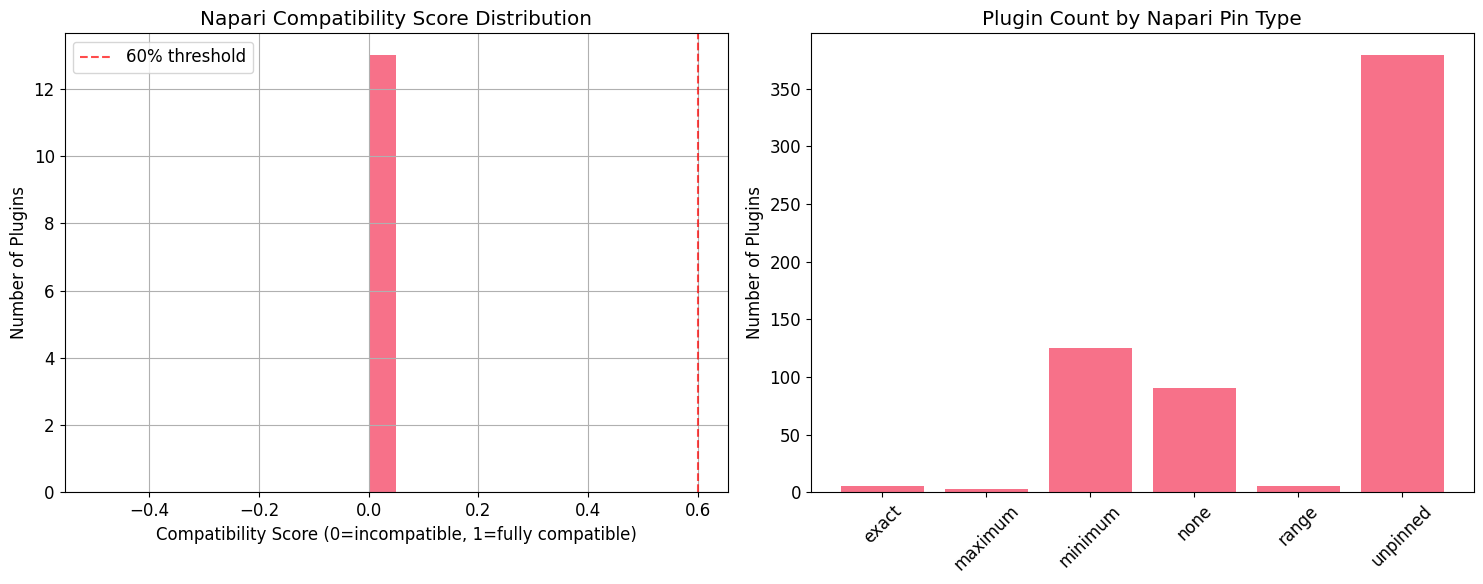

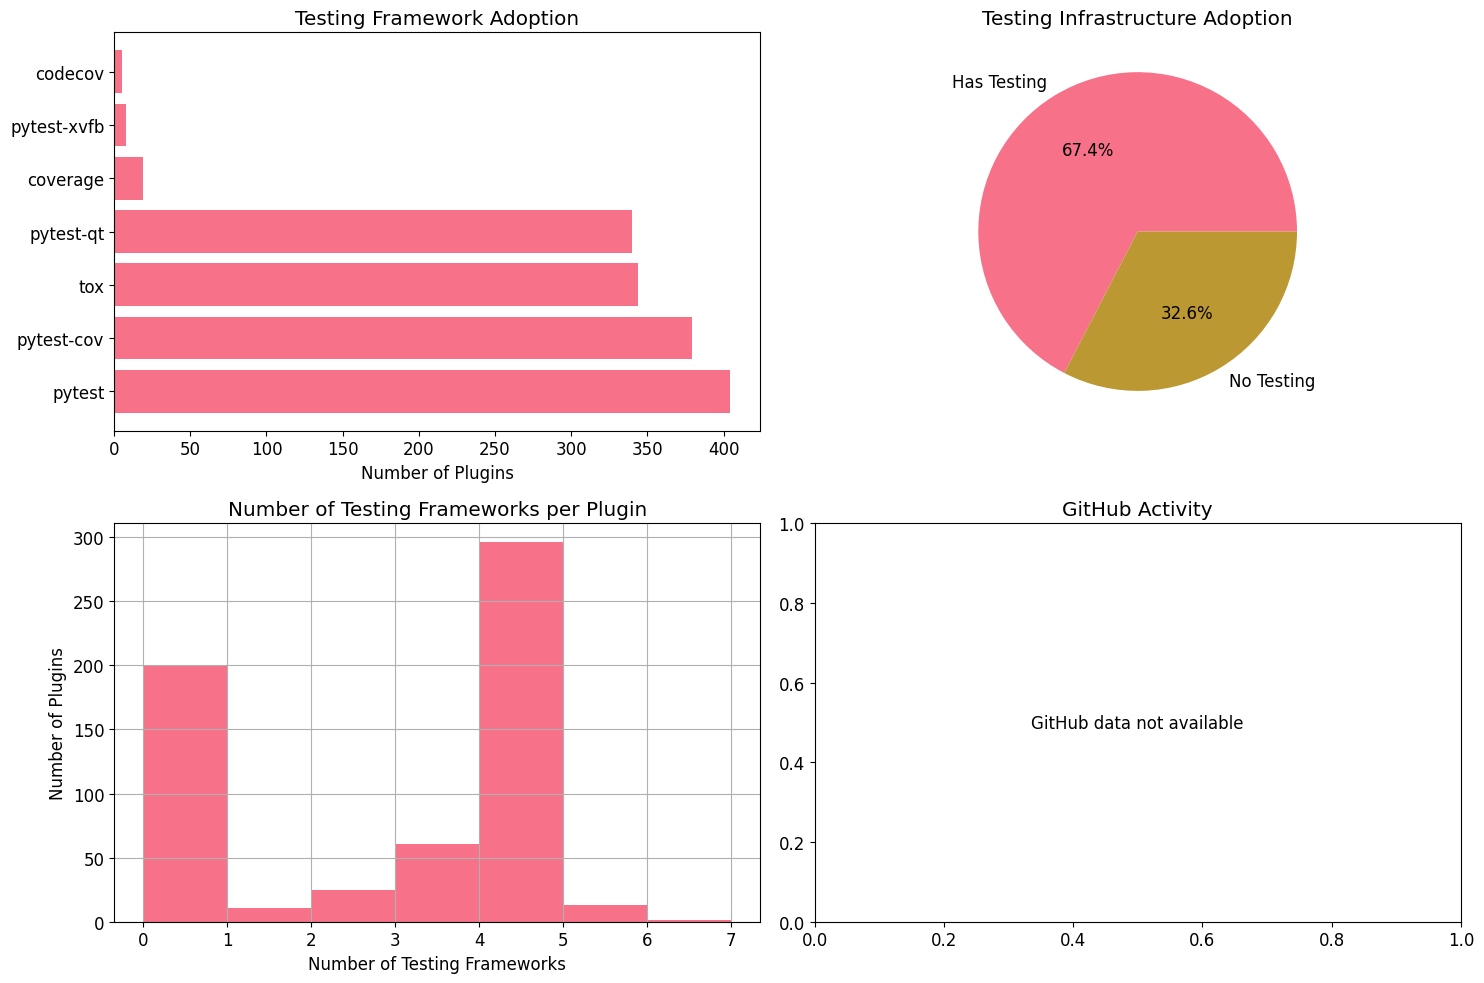

🌟 Ecosystem Health Summary:
Total plugins analyzed: 607
Average health score: 0.83/1.0
Plugins with perfect health score: 369
Plugins needing attention (score < 0.5): 63


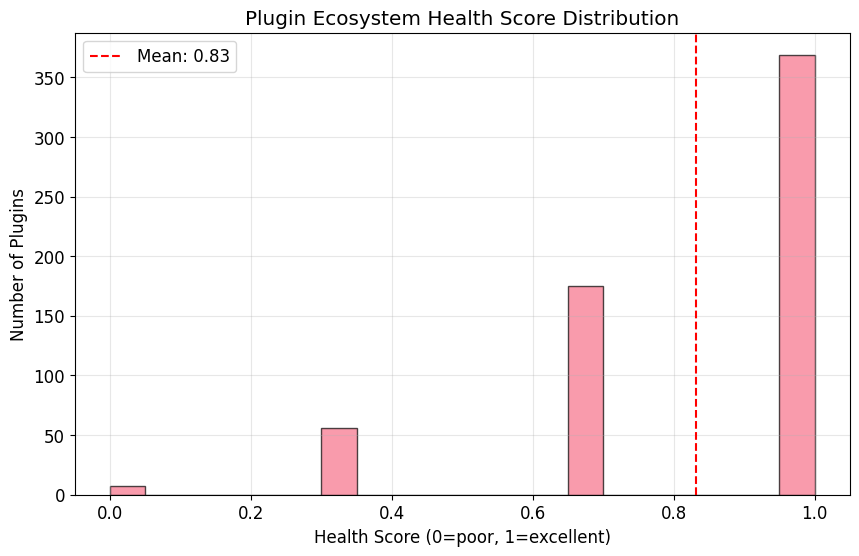


📊 Visualizations saved to: reports/
Generated files:
- ecosystem_overview.png
- napari_compatibility.png
- testing_and_activity.png
- ecosystem_health_distribution.png


In [8]:
# Create comprehensive visualizations

# 1. Python Version Support Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Python version support histogram
python_support_df['num_python_versions'].hist(bins=range(0, 15), ax=axes[0,0])
axes[0,0].set_title('Distribution of Python Versions Supported per Plugin')
axes[0,0].set_xlabel('Number of Python Versions Supported')
axes[0,0].set_ylabel('Number of Plugins')

# Most common Python versions
if all_versions:
    version_counts = Counter(all_versions)
    top_versions = dict(version_counts.most_common(8))
    
    axes[0,1].bar(top_versions.keys(), top_versions.values())
    axes[0,1].set_title('Most Popular Python Versions')
    axes[0,1].set_xlabel('Python Version')
    axes[0,1].set_ylabel('Number of Plugins')
    axes[0,1].tick_params(axis='x', rotation=45)

# Napari dependency pin types
pin_type_counts = napari_deps_df['napari_pin_type'].value_counts()
axes[1,0].pie(pin_type_counts.values, labels=pin_type_counts.index, autopct='%1.1f%%')
axes[1,0].set_title('Napari Dependency Pin Types')

# Testing infrastructure adoption
testing_stats = {
    'Has Testing Deps': testing_df['has_testing_deps'].sum(),
    'Uses pytest': testing_df['has_pytest'].sum(), 
    'Has Coverage': testing_df['has_coverage'].sum(),
    'Uses tox': testing_df['has_tox'].sum()
}

axes[1,1].bar(testing_stats.keys(), testing_stats.values())
axes[1,1].set_title('Testing Infrastructure Adoption')
axes[1,1].set_ylabel('Number of Plugins')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'ecosystem_overview.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Napari Compatibility Analysis
if not compat_summary_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Compatibility score distribution
    compat_summary_df['compatibility_score'].hist(bins=20, ax=axes[0])
    axes[0].set_title('Napari Compatibility Score Distribution')
    axes[0].set_xlabel('Compatibility Score (0=incompatible, 1=fully compatible)')
    axes[0].set_ylabel('Number of Plugins')
    axes[0].axvline(x=0.6, color='red', linestyle='--', alpha=0.7, label='60% threshold')
    axes[0].legend()
    
    # Compatibility by pin type
    if len(napari_deps_df) > 0:
        compat_by_pin = napari_deps_df.groupby('napari_pin_type').size()
        axes[1].bar(compat_by_pin.index, compat_by_pin.values)
        axes[1].set_title('Plugin Count by Napari Pin Type')
        axes[1].set_ylabel('Number of Plugins')
        axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'napari_compatibility.png', dpi=300, bbox_inches='tight')
    plt.show()

# 3. Testing Infrastructure Deep Dive
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Testing framework popularity
if all_frameworks:
    framework_counts = Counter(all_frameworks)
    top_frameworks = dict(framework_counts.most_common(8))
    
    axes[0,0].barh(list(top_frameworks.keys()), list(top_frameworks.values()))
    axes[0,0].set_title('Testing Framework Adoption')
    axes[0,0].set_xlabel('Number of Plugins')

# Testing vs No Testing
testing_adoption = [
    testing_df['has_testing_deps'].sum(),
    len(testing_df) - testing_df['has_testing_deps'].sum()
]
axes[0,1].pie(testing_adoption, labels=['Has Testing', 'No Testing'], autopct='%1.1f%%')
axes[0,1].set_title('Testing Infrastructure Adoption')

# Number of testing frameworks per plugin
testing_df['num_testing_frameworks'].hist(bins=range(0, 8), ax=axes[1,0])
axes[1,0].set_title('Number of Testing Frameworks per Plugin')
axes[1,0].set_xlabel('Number of Testing Frameworks')
axes[1,0].set_ylabel('Number of Plugins')

# GitHub activity if available
if github_data and 'github_activity_df' in locals():
    # Stars distribution (log scale)
    non_zero_stars = github_activity_df[github_activity_df['stars'] > 0]['stars']
    if not non_zero_stars.empty:
        axes[1,1].hist(non_zero_stars, bins=20, alpha=0.7)
        axes[1,1].set_xscale('log')
        axes[1,1].set_title('GitHub Stars Distribution (log scale)')
        axes[1,1].set_xlabel('Number of Stars')
        axes[1,1].set_ylabel('Number of Plugins')
    else:
        axes[1,1].text(0.5, 0.5, 'No GitHub stars data', ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('GitHub Stars Distribution')
else:
    axes[1,1].text(0.5, 0.5, 'GitHub data not available', ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('GitHub Activity')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'testing_and_activity.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Ecosystem Health Heatmap
# Create a combined dataset for ecosystem health analysis
ecosystem_health = python_support_df.merge(
    napari_deps_df[['plugin_name', 'has_napari_dependency', 'napari_pin_type']], 
    on='plugin_name', 
    how='left'
).merge(
    testing_df[['plugin_name', 'has_testing_deps', 'num_testing_frameworks']], 
    on='plugin_name', 
    how='left'
)

# Create health score
ecosystem_health['python_score'] = (ecosystem_health['num_python_versions'] > 0).astype(int)
ecosystem_health['napari_score'] = ecosystem_health['has_napari_dependency'].fillna(0).astype(int)
ecosystem_health['testing_score'] = ecosystem_health['has_testing_deps'].fillna(0).astype(int)
ecosystem_health['health_score'] = (
    ecosystem_health['python_score'] + 
    ecosystem_health['napari_score'] + 
    ecosystem_health['testing_score']
) / 3

# Ecosystem summary statistics
print("🌟 Ecosystem Health Summary:")
print(f"Total plugins analyzed: {len(ecosystem_health)}")
print(f"Average health score: {ecosystem_health['health_score'].mean():.2f}/1.0")
print(f"Plugins with perfect health score: {(ecosystem_health['health_score'] == 1.0).sum()}")
print(f"Plugins needing attention (score < 0.5): {(ecosystem_health['health_score'] < 0.5).sum()}")

# Health score distribution
plt.figure(figsize=(10, 6))
ecosystem_health['health_score'].hist(bins=20, alpha=0.7, edgecolor='black')
plt.axvline(x=ecosystem_health['health_score'].mean(), color='red', linestyle='--', 
           label=f'Mean: {ecosystem_health["health_score"].mean():.2f}')
plt.title('Plugin Ecosystem Health Score Distribution')
plt.xlabel('Health Score (0=poor, 1=excellent)')
plt.ylabel('Number of Plugins')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(OUTPUT_DIR / 'ecosystem_health_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Visualizations saved to: {OUTPUT_DIR}/")
print("Generated files:")
print("- ecosystem_overview.png")
print("- napari_compatibility.png") 
print("- testing_and_activity.png")
print("- ecosystem_health_distribution.png")

## 8. Export Analysis Results

Save comprehensive analysis results to structured formats for further use.

In [9]:
# Export comprehensive analysis results

# 1. Save individual analysis dataframes
print("💾 Exporting analysis results...")

# Export Python version support analysis
python_support_df.to_csv(OUTPUT_DIR / 'python_version_support.csv', index=False)
print("✓ Python version support data exported")

# Export napari dependency analysis
napari_deps_df.to_csv(OUTPUT_DIR / 'napari_dependencies.csv', index=False)
print("✓ Napari dependency data exported")

# Export testing infrastructure analysis
testing_df.to_csv(OUTPUT_DIR / 'testing_infrastructure.csv', index=False)
print("✓ Testing infrastructure data exported")

# Export ecosystem health summary
ecosystem_health.to_csv(OUTPUT_DIR / 'ecosystem_health.csv', index=False)
print("✓ Ecosystem health data exported")

# Export compatibility analysis if available
if 'compat_summary_df' in locals() and not compat_summary_df.empty:
    compat_summary_df.to_csv(OUTPUT_DIR / 'compatibility_analysis.csv', index=False)
    print("✓ Compatibility analysis exported")

# Export GitHub activity if available
if 'github_activity_df' in locals():
    github_activity_df.to_csv(OUTPUT_DIR / 'github_activity.csv', index=False)
    print("✓ GitHub activity data exported")

# 2. Generate comprehensive JSON summary
summary_stats = {
    'analysis_metadata': {
        'generation_date': pd.Timestamp.now().isoformat(),
        'total_plugins_analyzed': len(ecosystem_health),
        'data_sources': ['npe2api_pypi', 'npe2api_github', 'npe2api_classifiers']
    },
    'python_version_support': {
        'plugins_with_version_info': int(python_support_df['num_python_versions'].gt(0).sum()),
        'average_versions_per_plugin': float(python_support_df['num_python_versions'].mean()),
        'most_common_versions': dict(Counter(all_versions).most_common(5)) if all_versions else {},
        'python3_adoption_rate': float(python_support_df['supports_python_3'].mean())
    },
    'napari_dependencies': {
        'plugins_with_napari_deps': int(napari_deps_df['has_napari_dependency'].sum()),
        'dependency_pin_distribution': napari_deps_df['napari_pin_type'].value_counts().to_dict(),
        'compatibility_categories': napari_deps_df['compatibility_category'].value_counts().to_dict()
    },
    'testing_infrastructure': {
        'plugins_with_tests': int(testing_df['has_testing_deps'].sum()),
        'pytest_adoption_rate': float(testing_df['has_pytest'].mean()),
        'coverage_adoption_rate': float(testing_df['has_coverage'].mean()),
        'tox_adoption_rate': float(testing_df['has_tox'].mean()),
        'framework_popularity': dict(Counter(all_frameworks).most_common()) if all_frameworks else {}
    },
    'ecosystem_health': {
        'average_health_score': float(ecosystem_health['health_score'].mean()),
        'perfect_health_plugins': int((ecosystem_health['health_score'] == 1.0).sum()),
        'needs_attention_plugins': int((ecosystem_health['health_score'] < 0.5).sum()),
        'health_score_distribution': ecosystem_health['health_score'].describe().to_dict()
    }
}

# Add compatibility analysis if available
if 'compat_summary_df' in locals() and not compat_summary_df.empty:
    summary_stats['compatibility_analysis'] = {
        'plugins_analyzed': len(compat_summary_df),
        'average_compatibility_score': float(compat_summary_df['compatibility_score'].mean()),
        'fully_compatible_plugins': int((compat_summary_df['compatibility_score'] == 1.0).sum()),
        'problematic_plugins': int((compat_summary_df['compatibility_score'] < 0.5).sum())
    }

# Add GitHub activity if available
if 'github_activity_df' in locals():
    summary_stats['github_activity'] = {
        'repositories_analyzed': len(github_activity_df),
        'archived_repositories': int(github_activity_df['is_archived'].sum()),
        'average_stars': float(github_activity_df['stars'].mean()),
        'average_forks': float(github_activity_df['forks'].mean()),
        'average_open_issues': float(github_activity_df['open_issues'].mean()),
        'repositories_with_vulnerabilities': int(github_activity_df['vulnerability_alerts'].gt(0).sum())
    }

# Save JSON summary
with open(OUTPUT_DIR / 'ecosystem_analysis_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2, default=str)
print("✓ JSON summary exported")

# 3. Generate markdown report
report_lines = [
    "# Napari Plugin Ecosystem Analysis Report",
    f"Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}",
    "",
    "## Executive Summary",
    f"This analysis covers **{len(ecosystem_health)} napari plugins** from the npe2api dataset.",
    f"Overall ecosystem health score: **{ecosystem_health['health_score'].mean():.1%}**",
    "",
    "## Key Findings",
    "",
    "### Python Version Support",
    f"- {python_support_df['num_python_versions'].gt(0).sum()} plugins ({python_support_df['num_python_versions'].gt(0).mean():.1%}) specify Python version requirements",
    f"- {python_support_df['supports_python_3'].sum()} plugins ({python_support_df['supports_python_3'].mean():.1%}) support Python 3",
    f"- Average of {python_support_df['num_python_versions'].mean():.1f} Python versions supported per plugin",
    "",
    "### Napari Dependencies",
    f"- {napari_deps_df['has_napari_dependency'].sum()} plugins ({napari_deps_df['has_napari_dependency'].mean():.1%}) explicitly depend on napari",
    f"- Most common pin type: {napari_deps_df['napari_pin_type'].mode().iloc[0] if not napari_deps_df.empty else 'N/A'}",
    "",
    "### Testing Infrastructure",  
    f"- {testing_df['has_testing_deps'].sum()} plugins ({testing_df['has_testing_deps'].mean():.1%}) have testing dependencies",
    f"- {testing_df['has_pytest'].sum()} plugins ({testing_df['has_pytest'].mean():.1%}) use pytest",
    f"- {testing_df['has_coverage'].sum()} plugins ({testing_df['has_coverage'].mean():.1%}) use coverage tools",
    "",
    "### Ecosystem Health",
    f"- {(ecosystem_health['health_score'] == 1.0).sum()} plugins ({(ecosystem_health['health_score'] == 1.0).mean():.1%}) have perfect health scores",
    f"- {(ecosystem_health['health_score'] < 0.5).sum()} plugins ({(ecosystem_health['health_score'] < 0.5).mean():.1%}) need attention",
    "",
    "## Recommendations",
    "1. **Python Version Support**: Encourage plugins to specify Python version requirements",
    "2. **Testing Infrastructure**: Promote adoption of pytest and coverage tools", 
    "3. **Napari Dependencies**: Review plugins with restrictive napari pins for compatibility",
    "4. **Documentation**: Improve plugin metadata completeness",
    "",
    "---",
    "*This report was generated automatically from npe2api data.*"
]

with open(OUTPUT_DIR / 'ecosystem_analysis_report.md', 'w') as f:
    f.write('\n'.join(report_lines))
print("✓ Markdown report generated")

# 4. Identify plugins needing attention
attention_needed = ecosystem_health[ecosystem_health['health_score'] < 0.5].copy()
if not attention_needed.empty:
    attention_needed = attention_needed.sort_values('health_score')[
        ['plugin_name', 'health_score', 'python_score', 'napari_score', 'testing_score']
    ]
    attention_needed.to_csv(OUTPUT_DIR / 'plugins_needing_attention.csv', index=False)
    print(f"✓ {len(attention_needed)} plugins needing attention exported")

# 5. Export top performers for reference
top_performers = ecosystem_health[ecosystem_health['health_score'] == 1.0].copy()
if not top_performers.empty:
    top_performers = top_performers[
        ['plugin_name', 'health_score', 'num_python_versions', 'napari_pin_type', 'num_testing_frameworks']
    ]
    top_performers.to_csv(OUTPUT_DIR / 'top_performing_plugins.csv', index=False)
    print(f"✓ {len(top_performers)} top performing plugins exported")

print(f"\n📁 All files exported to: {OUTPUT_DIR}/")
print("\nGenerated files:")
for file in OUTPUT_DIR.glob('*'):
    if file.is_file():
        print(f"  - {file.name}")

print(f"\n🎉 Analysis complete! Check the {OUTPUT_DIR} directory for all results.")
print("📊 Key insights:")
print(f"   • {len(ecosystem_health)} plugins analyzed")
print(f"   • {ecosystem_health['health_score'].mean():.1%} average ecosystem health")
print(f"   • {(ecosystem_health['health_score'] < 0.5).sum()} plugins need attention")
print(f"   • {testing_df['has_testing_deps'].mean():.1%} have testing infrastructure")

💾 Exporting analysis results...
✓ Python version support data exported
✓ Napari dependency data exported
✓ Testing infrastructure data exported
✓ Ecosystem health data exported
✓ Compatibility analysis exported
✓ JSON summary exported
✓ Markdown report generated
✓ 63 plugins needing attention exported
✓ 369 top performing plugins exported

📁 All files exported to: reports/

Generated files:
  - compatibility_analysis.csv
  - distribution_patterns.png
  - ecosystem_analysis_report.md
  - ecosystem_analysis_summary.json
  - ecosystem_health.csv
  - ecosystem_health_distribution.png
  - ecosystem_overview.png
  - ecosystem_report_20250926_145409.md
  - ecosystem_summary.png
  - latest_ecosystem_report.md
  - license_distribution.png
  - napari_compatibility.png
  - napari_dependencies.csv
  - plugins_needing_attention.csv
  - plugin_categories.png
  - python_version_support.csv
  - testing_and_activity.png
  - testing_infrastructure.csv
  - top_performing_plugins.csv
  - version_distribut